<a href="https://colab.research.google.com/github/zolfaShefreie/Heating-Cooling-Load-Prediction/blob/main/EnergyEfficiency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ماژول برای اندازه‌گیری متریک‌ها در آموزش یک مدل در تنسورفلو

In [1]:
!pip install tensorflow_addons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

#Download Dataset

مجموعه‌داده‌های آموزش و تست در مخزن گیت‌هاب پروژه [مخزن گیت‌هاب پروژه ](https://github.com/zolfaShefreie/Heating-Cooling-Load-Prediction)  قرار داده شده است که کد زیر برای دانلود کردن آنها می‌باشد 

In [4]:
def download_file(url: str, file_path):
  """
  download file and save on file path
  """
  file_content = requests.get(url).text
  file = open(file_path, 'w')
  file.write(file_content)
  file.close()

In [5]:
train_url = 'https://raw.githubusercontent.com/zolfaShefreie/Heating-Cooling-Load-Prediction/main/01.train.csv'
test_url = 'https://raw.githubusercontent.com/zolfaShefreie/Heating-Cooling-Load-Prediction/main/02.test.csv'

train_file_path = "train.csv"
test_file_path = "test.csv"

In [6]:
download_file(train_url, train_file_path)
download_file(test_url, test_file_path)

#Load Dataset

In [7]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

نسبت داده‌های آموزش و تست

In [8]:
train_df.shape, test_df.shape

((668, 10), (100, 10))

#Analyse Dataset

برای آنالیز داده دو مجموعه داده را با یکدیگر ادغام می‌کنیم تا نتایج بررسی شود

In [9]:
total_df = train_df.append(test_df, ignore_index=True)
total_df.shape

(768, 10)

مقادیر نال در مجموعه داده وجود ندارد

In [10]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


مقادیر اوت لایر و غیر عادی دیده نمی شود

In [11]:
total_df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


تمام ستون‌ها به جز ستون‌های برچسب حالت کتگوریکال دارند یعنی عناصر یونیک آنها محدوده این موارد ممکن به علت وجود استاندارد خاص باشد و امکان گسسته سازی آن نیز وجود دارد

In [12]:
for column in total_df.columns:
  print(column, " ",total_df[column].unique())

Relative_Compactness   [0.76 0.98 0.74 0.9  0.86 0.62 0.82 0.69 0.66 0.71 0.64 0.79]
Surface_Area   [661.5 514.5 686.  563.5 588.  808.5 612.5 735.  759.5 710.5 784.  637. ]
Wall_Area   [416.5 294.  245.  318.5 367.5 269.5 343. ]
Roof_Area   [122.5  110.25 220.5  147.  ]
Overall_Height   [7.  3.5]
Orientation   [2 4 5 3]
Glazing_Area   [0.4  0.25 0.1  0.  ]
Glazing_Area_Distribution   [1 5 3 2 4 0]
Heating_Load   [40.78 28.37 10.36 29.83 29.43 16.76 22.58 16.44 14.08 12.41 33.12 32.31
 24.63 14.72 11.69 14.66 11.2  10.39 12.12 19.68 29.06 11.16 23.93 14.6
 29.68 17.88 14.53 35.48 24.23 39.97 15.55 13.97 14.4  19.   32.06 42.96
 14.5  18.88 10.75 40.6  28.55 31.53 35.73 11.42 10.07 28.09 35.01 38.98
 36.66 29.34 29.54 12.17 23.53 18.9  29.27 32.84 11.43 32.46 35.96 39.86
 16.94 15.42 16.84 15.16 24.17 32.12 11.49  8.6  32.94 10.47 32.67 12.8
 41.26 14.19 33.28 32.52  6.37 14.75 35.69 14.17 32.68 15.41 28.7  12.63
 42.74 20.71 15.3  36.28 10.43 38.57 39.83 24.4  12.18 28.41 11.45 14.58
 

طبق نتایج زیر مقادیر اوت لایر برای این دو ویژگی مشاهده نمی‌شود.

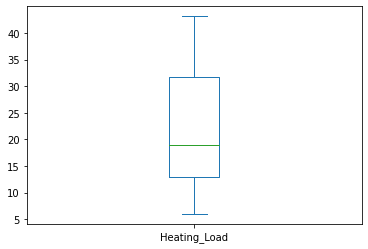

In [13]:
total_df[['Heating_Load']].plot.box()

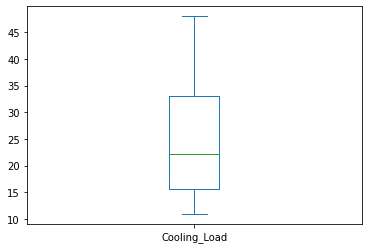

In [14]:
total_df[['Cooling_Load']].plot.box()

رابطه‌هایی بین موارد زیر دیده می‌شود که نیاز به بررسی بیشتر دارد:<br/>


*   relative_Compactness and surface area
*   relative_Compactness and roof area
*   relative_Compactness and overall height
*   surface area and overall height
*   surface area and roof area
*   roof area and heating load and cooling load
*   roof area and overall height
*   overall height and heating load and cooling load



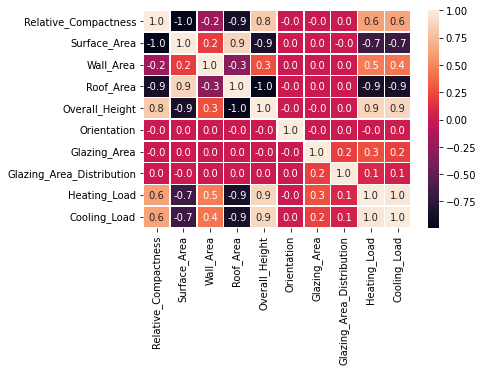

In [15]:
sns.heatmap(total_df.corr(), annot=True, linewidths=.5, fmt= '.1f')

## Relative_Compactness and Surface_Area and Roof_Area and Overall_Height

همانطور که در شکل زیر مشاهده می‌شود هرچه سرفیس بیشتر می‌شود ریلتیو کامپتنس کمتر می‌شود و هر مقدار از آنها را می‌توان به یکدیگر مپ کرد و از هر کدام دقیقا ۶۴ مورد موجود است بنابراین امکان حذف یکی از ویژگی‌ها وجود دارد.

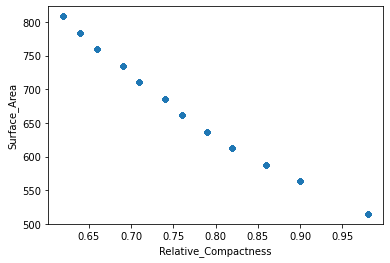

In [16]:
total_df.plot.scatter('Relative_Compactness', 'Surface_Area')

In [17]:
total_df[['Relative_Compactness', "Surface_Area"]].groupby(['Relative_Compactness', "Surface_Area"]).size()

Relative_Compactness  Surface_Area
0.62                  808.5           64
0.64                  784.0           64
0.66                  759.5           64
0.69                  735.0           64
0.71                  710.5           64
0.74                  686.0           64
0.76                  661.5           64
0.79                  637.0           64
0.82                  612.5           64
0.86                  588.0           64
0.90                  563.5           64
0.98                  514.5           64
dtype: int64

چند دسته از ریلتت کامپکتنس در یک دسته از روف اریا قرار می‌گیرد و در بیشتر حالت‌ها با افزایش روف اریا، ریلیتت کامپکتنس هم افزایش می‌یابد

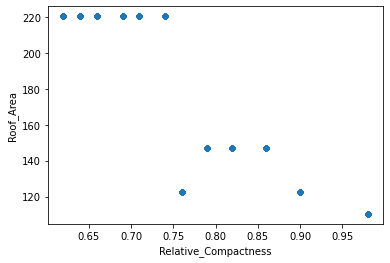

In [18]:
total_df.plot.scatter('Relative_Compactness', 'Roof_Area')

In [19]:
total_df[['Relative_Compactness', "Roof_Area"]].groupby(['Relative_Compactness', "Roof_Area"]).size()

Relative_Compactness  Roof_Area
0.62                  220.50       64
0.64                  220.50       64
0.66                  220.50       64
0.69                  220.50       64
0.71                  220.50       64
0.74                  220.50       64
0.76                  122.50       64
0.79                  147.00       64
0.82                  147.00       64
0.86                  147.00       64
0.90                  122.50       64
0.98                  110.25       64
dtype: int64

چند دسته از سرفیس اریا در یک دسته از روف اریا قرار می‌گیرند که در بیشتر موارد رابطه‌ی مستیقیم با یکدیگر دارند

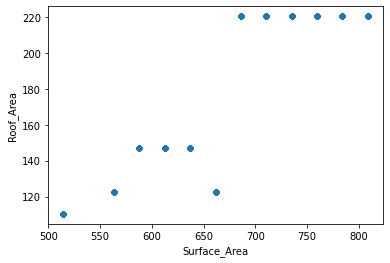

In [20]:
total_df.plot.scatter('Surface_Area', 'Roof_Area')

In [21]:
total_df[['Roof_Area', "Surface_Area"]].groupby(['Roof_Area', "Surface_Area"]).size()

Roof_Area  Surface_Area
110.25     514.5           64
122.50     563.5           64
           661.5           64
147.00     588.0           64
           612.5           64
           637.0           64
220.50     686.0           64
           710.5           64
           735.0           64
           759.5           64
           784.0           64
           808.5           64
dtype: int64

اورال هایت دو دسته دارد که موارد دیگر در این دو دسته تقسیم می‌شوند

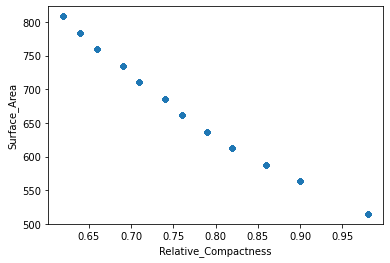

In [22]:
total_df.plot.scatter('Relative_Compactness', 'Surface_Area')

In [23]:
total_df[['Relative_Compactness', "Overall_Height"]].groupby(['Overall_Height', "Relative_Compactness"]).size()

Overall_Height  Relative_Compactness
3.5             0.62                    64
                0.64                    64
                0.66                    64
                0.69                    64
                0.71                    64
                0.74                    64
7.0             0.76                    64
                0.79                    64
                0.82                    64
                0.86                    64
                0.90                    64
                0.98                    64
dtype: int64

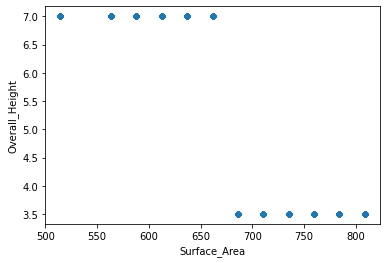

In [24]:
total_df.plot.scatter('Surface_Area', 'Overall_Height')

In [25]:
total_df[['Surface_Area', "Overall_Height"]].groupby(['Overall_Height', "Surface_Area"]).size()

Overall_Height  Surface_Area
3.5             686.0           64
                710.5           64
                735.0           64
                759.5           64
                784.0           64
                808.5           64
7.0             514.5           64
                563.5           64
                588.0           64
                612.5           64
                637.0           64
                661.5           64
dtype: int64

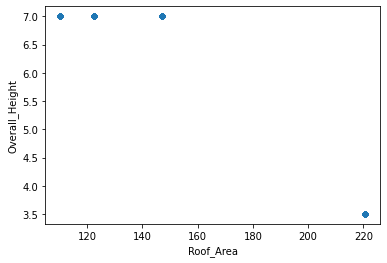

In [26]:
total_df.plot.scatter('Roof_Area', 'Overall_Height')

In [27]:
total_df[['Roof_Area', "Overall_Height"]].groupby(['Overall_Height', "Roof_Area"]).size()

Overall_Height  Roof_Area
3.5             220.50       384
7.0             110.25        64
                122.50       128
                147.00       192
dtype: int64

##plot based on a pair of features

کتگوریکال بودن بعضی از ویژگی‌ها هم در این جا مشخص است.

رابطه‌ی مستقیم خطی بین دو تارگت وجود دارد.

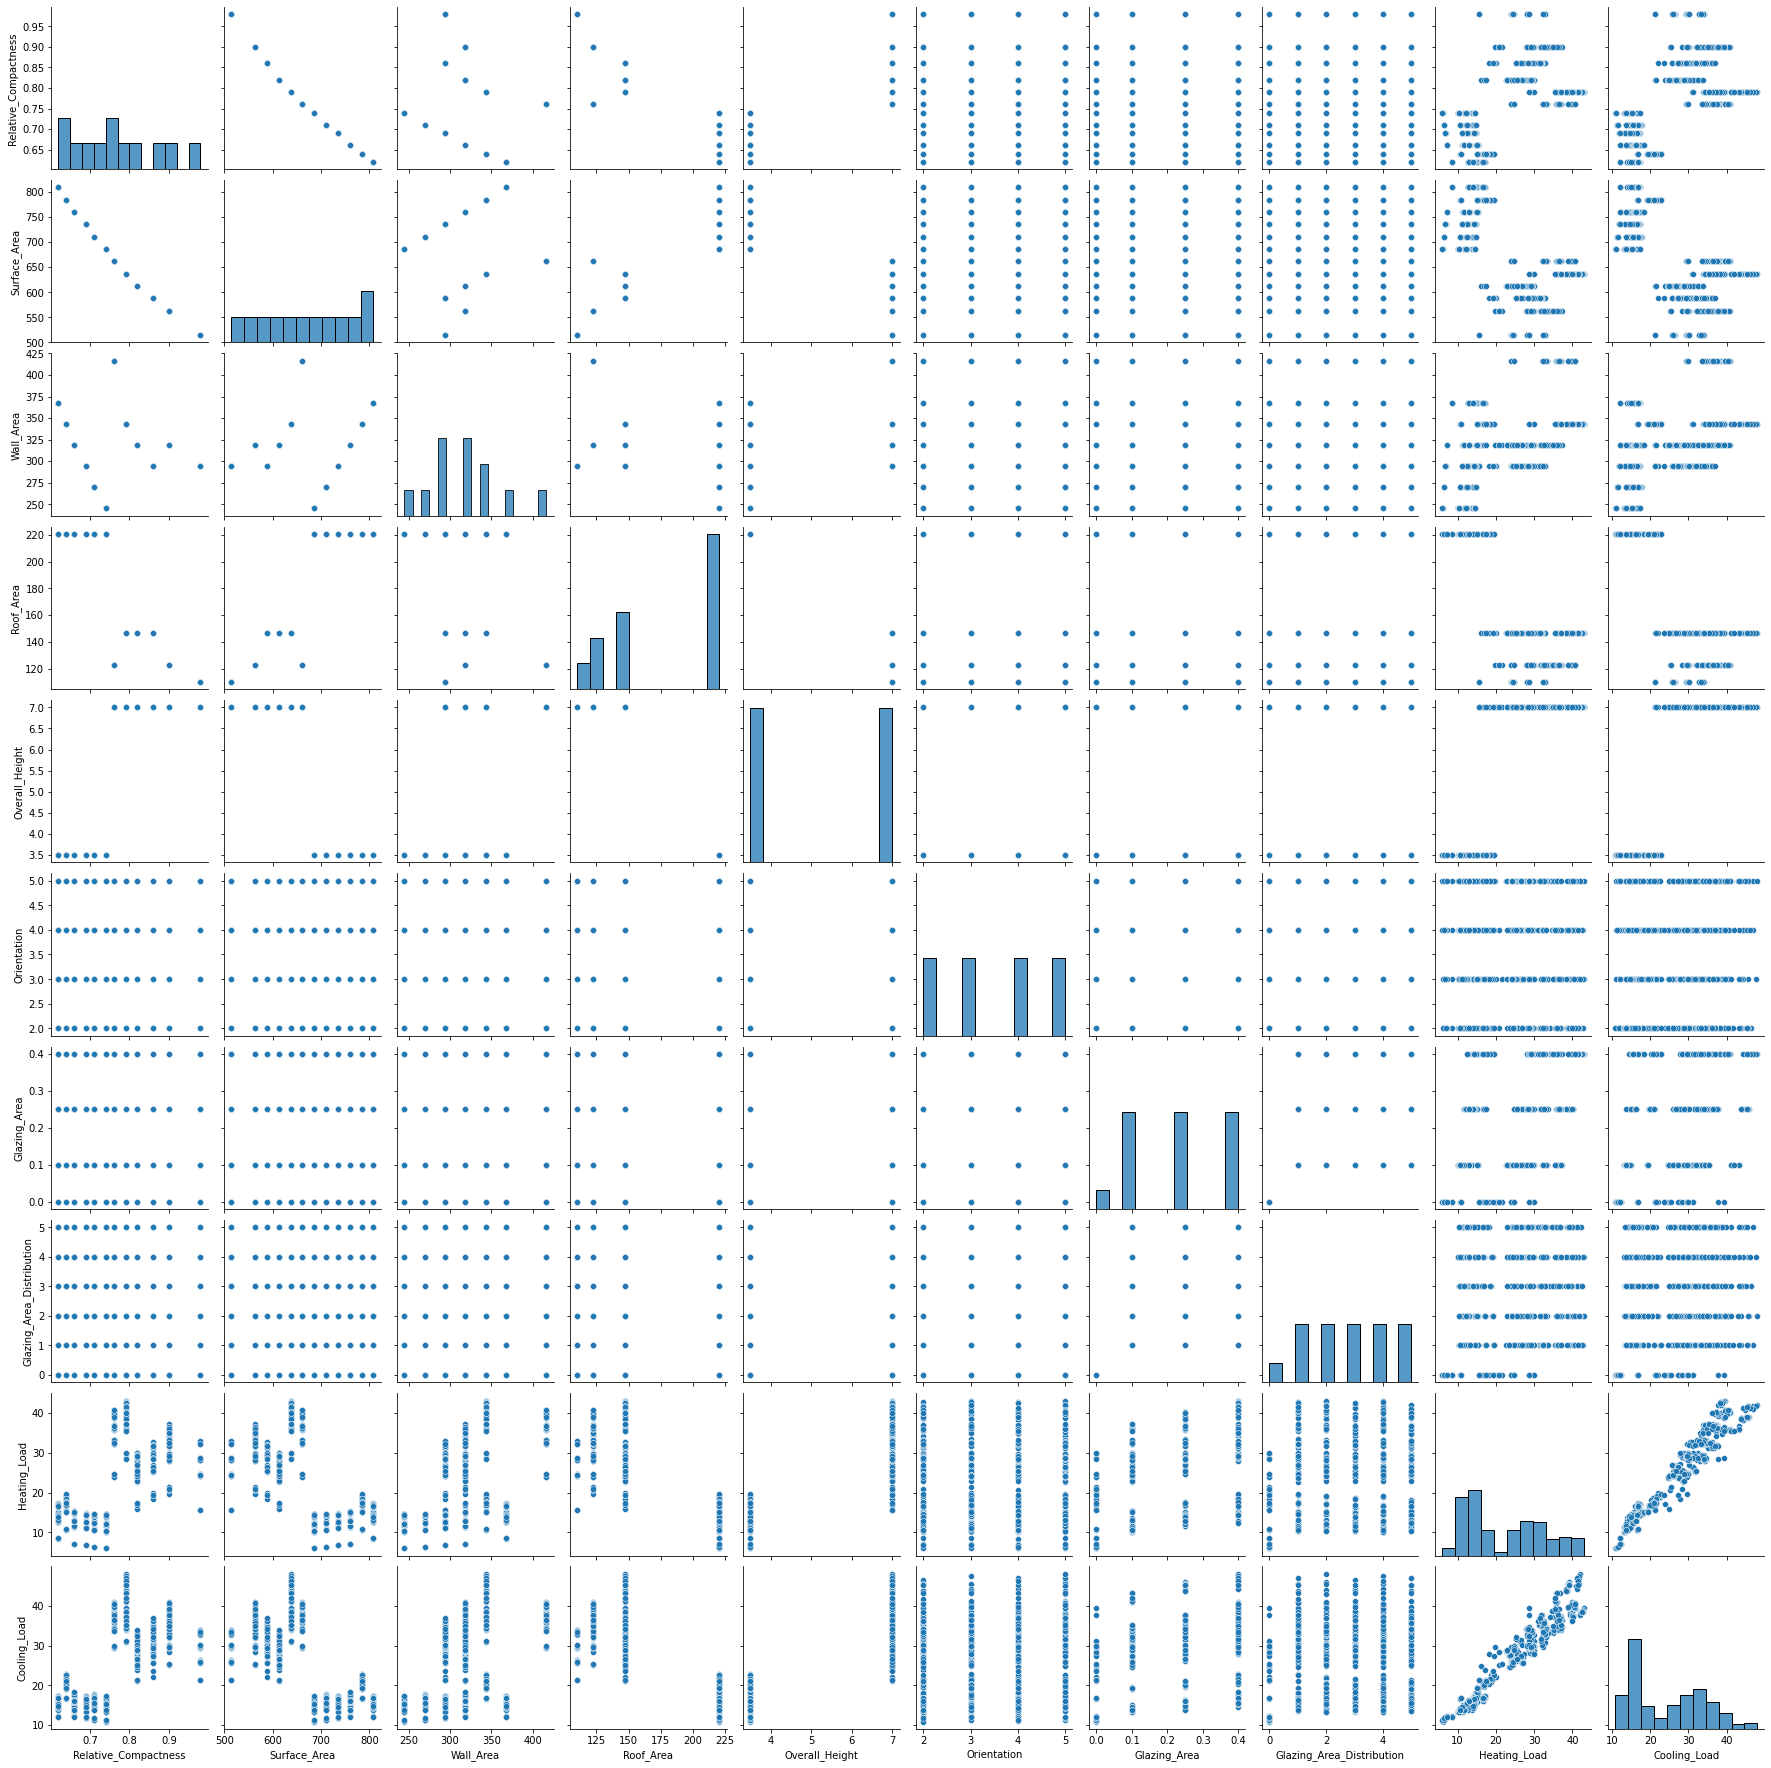

In [28]:
sns.pairplot(total_df)

#Predictions

##heating loading

###Preprocess Data

به‌دلیل تناظر یک به یک ریلیتیو کامپکتنس و سرفیس اریا یکی از آن‌ها می‌تواند حذف شود که در اینجا سرفیس اریا حذف شده است.

In [29]:
x_train = train_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_train = train_df[['Heating_Load']].copy()

x_test = test_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_test = test_df[['Heating_Load']].copy()

بار بالا به عنوان ۱ و بار پایین به‌عنوان بار پایین گذاشته می‌شوند

In [30]:
y_train.loc[y_train['Heating_Load'] < 18, 'Heating_Load'] = 0
y_train.loc[y_train['Heating_Load'] >= 18, 'Heating_Load'] = 1

y_test.loc[y_test['Heating_Load'] < 18, 'Heating_Load'] = 0
y_test.loc[y_test['Heating_Load'] >= 18, 'Heating_Load'] = 1

In [31]:
y_train.Heating_Load.unique()

array([1., 0.])

###Decision Tree

####Train Model

In [32]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(x_train, y_train.Heating_Load)

DecisionTreeClassifier()

[Text(0.45454545454545453, 0.9285714285714286, 'Relative_Compactness <= 0.75\ngini = 0.5\nsamples = 668\nvalue = [329, 339]'),
 Text(0.18181818181818182, 0.7857142857142857, 'Glazing_Area <= 0.325\ngini = 0.09\nsamples = 337\nvalue = [321, 16]'),
 Text(0.09090909090909091, 0.6428571428571429, 'gini = 0.0\nsamples = 225\nvalue = [225, 0]'),
 Text(0.2727272727272727, 0.6428571428571429, 'Relative_Compactness <= 0.65\ngini = 0.245\nsamples = 112\nvalue = [96, 16]'),
 Text(0.18181818181818182, 0.5, 'Relative_Compactness <= 0.63\ngini = 0.496\nsamples = 35\nvalue = [19, 16]'),
 Text(0.09090909090909091, 0.35714285714285715, 'gini = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(0.2727272727272727, 0.35714285714285715, 'Glazing_Area_Distribution <= 4.5\ngini = 0.111\nsamples = 17\nvalue = [1, 16]'),
 Text(0.18181818181818182, 0.21428571428571427, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(0.36363636363636365, 0.21428571428571427, 'Orientation <= 4.5\ngini = 0.444\nsamples = 3\nvalue = 

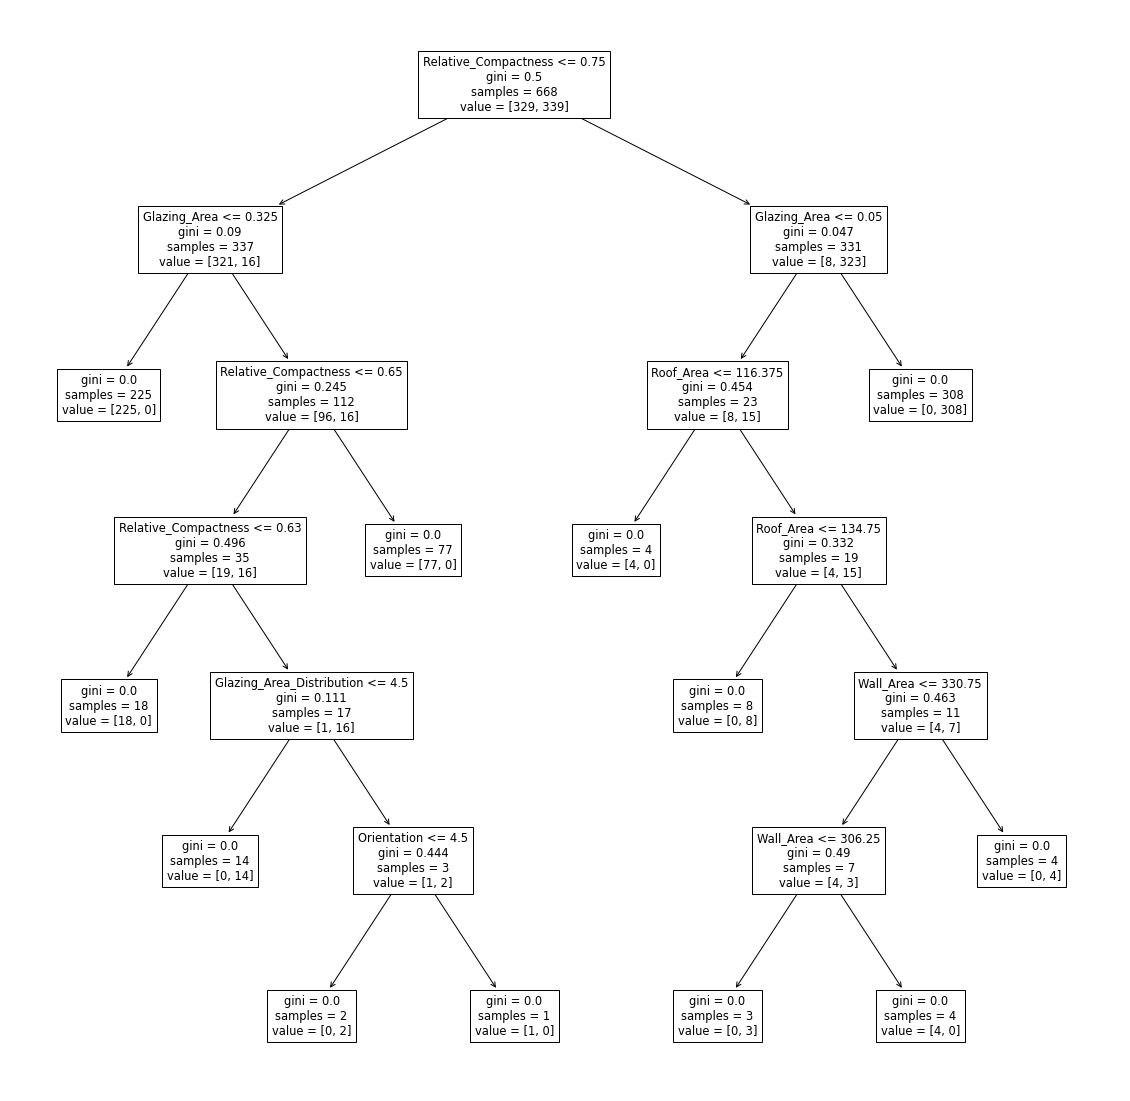

In [33]:
plt.figure(figsize=(20, 20))
plot_tree(dtc_model, feature_names=['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution'])

####Evaluate Model

In [34]:
y_predict = dtc_model.predict(x_test)

In [35]:
accuracy_score(y_test.Heating_Load, y_predict)

0.99

In [36]:
print(classification_report(y_test.Heating_Load, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.98      1.00      0.99        55

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [37]:
confusion_matrix(y_test.Heating_Load, y_predict)

array([[44,  1],
       [ 0, 55]])

In [38]:
TP = confusion_matrix(y_test.Heating_Load, y_predict)[0][0]
FN = confusion_matrix(y_test.Heating_Load, y_predict)[0][1]
FP = confusion_matrix(y_test.Heating_Load, y_predict)[1][0]
TN = confusion_matrix(y_test.Heating_Load, y_predict)[1][1]

In [39]:
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FN + FP + TN)
error = 1 - accuracy
f1 = 2 * precision * recall / (recall + precision)

In [40]:
print("sensitivity: ", sensitivity)
print("specificity: ", specificity)
print("precision: ", precision)
print("recall: ", recall)
print("accuracy", accuracy)
print("error: ", error)
print("f1: ", f1)

sensitivity:  0.9777777777777777
specificity:  1.0
precision:  1.0
recall:  0.9777777777777777
accuracy 0.99
error:  0.010000000000000009
f1:  0.9887640449438202


###Random Forest

####Train Model

In [41]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train.Heating_Load)

RandomForestClassifier()

####Evaluate Model

In [42]:
y_predict = rfc_model.predict(x_test)

In [43]:
print(classification_report(y_test.Heating_Load, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.98      1.00      0.99        55

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [44]:
accuracy_score(y_test.Heating_Load, y_predict)

0.99

In [45]:
confusion_matrix(y_test.Heating_Load, y_predict)

array([[44,  1],
       [ 0, 55]])

In [46]:
TP = confusion_matrix(y_test.Heating_Load, y_predict)[0][0]
FN = confusion_matrix(y_test.Heating_Load, y_predict)[0][1]
FP = confusion_matrix(y_test.Heating_Load, y_predict)[1][0]
TN = confusion_matrix(y_test.Heating_Load, y_predict)[1][1]

In [47]:
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FN + FP + TN)
error = 1 - accuracy
f1 = 2 * precision * recall / (recall + precision)

In [48]:
print("sensitivity: ", sensitivity)
print("specificity: ", specificity)
print("precision: ", precision)
print("recall: ", recall)
print("accuracy", accuracy)
print("error: ", error)
print("f1: ", f1)

sensitivity:  0.9777777777777777
specificity:  1.0
precision:  1.0
recall:  0.9777777777777777
accuracy 0.99
error:  0.010000000000000009
f1:  0.9887640449438202


###Compare

عملکرد دو مدل در این مسئله کاملا یکسان بوده است.<br/>
اما مدل رندوم فارست در بیشتر مسائل به‌علت ایجاد چندین درخت تصمیم در الگوریتم خود عملکرد بهتری نسبت به درخت تصمیم نشان می‌دهد.

## cooling loading

###Preprocess Data

به‌دلیل تناظر یک به یک ریلیتیو کامپکتنس و سرفیس اریا یکی از آن‌ها می‌تواند حذف شود که در اینجا سرفیس اریا حذف شده است.

In [49]:
x_train = train_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_train = train_df[['Cooling_Load']].copy()

x_test = test_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_test = test_df[['Cooling_Load']].copy()


In [50]:
x_train.shape

(668, 7)

In [51]:
bins = pd.cut(total_df.Cooling_Load, 5, retbins=True)[1]
bins

array([10.86287, 18.326  , 25.752  , 33.178  , 40.604  , 48.03   ])

In [52]:
y_train['Cooling_Load'] = pd.cut(y_train.Cooling_Load, bins=bins, labels=[i for i in range(5)])
y_test['Cooling_Load'] = pd.cut(y_test.Cooling_Load, bins=bins, labels=[i for i in range(5)])

In [53]:
y_train

,Cooling_Load
0,3
1,2
2,0
3,2
4,2
...,...
663,3
664,2
665,0
666,2


In [54]:
y_train.shape

(668, 1)

نرمال کردن ویژگی‌ها

In [55]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

###SVM

####tain model

In [56]:
svm = SVC()
svm.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

####evaluate model

طبق نتایج زیر این مدل برای دومین و آخرین برچسب هیچ پیش‌بینی درستی نداشته است

In [57]:
y_predict = svm.predict(x_test)

In [58]:
confusion_matrix(y_test.Cooling_Load, y_predict)

array([[37,  0,  0,  0,  0],
       [10,  0,  4,  0,  0],
       [ 0,  0, 16,  3,  0],
       [ 0,  0,  9, 16,  0],
       [ 0,  0,  3,  2,  0]])

In [59]:
print(classification_report(y_test.Cooling_Load, y_predict))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        14
           2       0.50      0.84      0.63        19
           3       0.76      0.64      0.70        25
           4       0.00      0.00      0.00         5

    accuracy                           0.69       100
   macro avg       0.41      0.50      0.44       100
weighted avg       0.58      0.69      0.62       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
accuracy_score(y_test.Cooling_Load, y_predict)

0.69

In [61]:
1 - accuracy_score(y_test.Cooling_Load, y_predict)

0.31000000000000005

###neural network

####Preprocess Data

این پردازش برای تبدیل لیبل به وان هات است که مدل به‌صورت باینری هر کدام از آن‌ها را پیش‌بینی کند

In [62]:
y_train_n = tf.keras.utils.to_categorical(y_train.Cooling_Load)
y_test_n = tf.keras.utils.to_categorical(y_test.Cooling_Load)

In [63]:
y_train_n.shape

(668, 5)

####train model

In [64]:
input_model = tf.keras.layers.Input(shape=(7, ))
dense_1 = tf.keras.layers.Dense(units=128, activation='relu')(input_model)
dense_2 = tf.keras.layers.Dense(units=64, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(units=20, activation='relu')(dense_2)
dense_4 = tf.keras.layers.Dense(5, activation='softmax')(dense_3)
model = tf.keras.models.Model(inputs=input_model, outputs=dense_4)
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=5,
                                           average='macro',
                                           threshold=0.5)])

In [65]:
model.fit(x=x_train, y=y_train_n, epochs=150)

Epoch 1/150
21/21 [==============================] - 2s 3ms/step - loss: 1.4005 - accuracy: 0.4940 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2/150
21/21 [==============================] - 0s 2ms/step - loss: 1.0158 - accuracy: 0.6572 - precision: 0.8382 - recall: 0.2560 - f1_score: 0.1526        
Epoch 3/150
21/21 [==============================] - 0s 2ms/step - loss: 0.8255 - accuracy: 0.7365 - precision: 0.8203 - recall: 0.5329 - f1_score: 0.3342
Epoch 4/150
21/21 [==============================] - 0s 3ms/step - loss: 0.7605 - accuracy: 0.7275 - precision: 0.7972 - recall: 0.6063 - f1_score: 0.3916
Epoch 5/150
21/21 [==============================] - 0s 4ms/step - loss: 0.7227 - accuracy: 0.7290 - precision: 0.7715 - recall: 0.6572 - f1_score: 0.4213
Epoch 6/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.7111 - precision: 0.7774 - recall: 0.6587 - f1_score: 0.4289
Epoch 7/150
21/21 [==============================]

####Evaluate model

مقادیر بدست آمده در نتیجه‌ی زیر به ترتیب:


*   loss
*   accuracy
*   precision
*   recall
*   f1_score



In [66]:
model.evaluate(x_test, y_test_n, verbose=0)

[0.2984025478363037,
 0.8500000238418579,
 0.8585858345031738,
 0.8500000238418579,
 0.7431034445762634]

###Compare

مدل شبکه‌ی عصبی عملکرد بهتری نسبت به SVM داشته است.